In [1]:
import numpy as np
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [3]:
class Actor(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Actor, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, a_dim))

        self.f = nn.Sequential(*layers)

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        out = self.f(state)
        #out = torch.tanh(out)
        out= F.softmax(out+1e-10, dim=-1)
        return out
    
    def sampling(self, state):

        probs = self(state)
        dist = Categorical(probs)
        sampled_actions = dist.sample()
        log_probs = dist.log_prob(sampled_actions).unsqueeze(1)
        return probs, log_probs


In [4]:
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))

        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        out = self.f(x)
        return out

In [5]:
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        # Two DNNs to mitigate positive bias
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)

    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

In [6]:
class SAC():
    def __init__(self, s_dim, a_dim, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, lambd=0.005, target_upd_inter=1, 
                 buffer_capacity=1000, batch_size=32, grad_steps = 1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_capacity)
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        self.tau = tau
        self.target_upd_inter = target_upd_inter

        self.actor = Actor(s_dim, a_dim, hidden_dim_actor, num_hidden_layers=num_layer_actor).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)

        # Stabilize training
        self.critic_target = copy.deepcopy(self.critic).to(device)
        for p in self.critic_target.parameters():
            p.requires_grad = False

    def choose_action(self, state):
        self.actor.eval()
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state.to(self.device))
            dist = Categorical(action_probs)
            action = dist.sample()
        return action.item(), action_probs.squeeze().detach().cpu().numpy()

    def train(self, update_interval):
        if len(self.buffer) < self.batch_size:
            return None, None

        for i in range(self.grad_steps):
            batch = random.sample(self.buffer, self.batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.tensor(states, dtype=torch.float32).to(self.device)
            actions = torch.tensor(actions, dtype=torch.float32).squeeze().to(self.device)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
            next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
            dones = torch.tensor(dones, dtype=torch.float32).to(self.device)
            #print(dones)
            
            # # Critic train
            # self.critic.train()
            
            with torch.no_grad():
                probs = self.actor(next_states)
                dist = Categorical(probs)
                sampled_actions = dist.sample()
                next_actions_log_probs = dist.log_prob(sampled_actions).unsqueeze(1)
                q1_next, q2_next = self.critic_target(next_states, probs)
                min_q_next = torch.min(q1_next, q2_next)
                #print((torch.ones_like(dones)-dones).shape)
                target_q_value = rewards + self.gamma *(torch.ones_like(dones)-dones).unsqueeze(1)*(min_q_next - self.alpha * next_actions_log_probs)#.sum(-1, keepdim=True))
                
            q1, q2 = self.critic(states, actions)
            
            critic_loss = F.mse_loss(q1, target_q_value.detach()) + F.mse_loss(q2, target_q_value.detach())

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Actor train
            self.actor.train()

            probs = self.actor(states)
            dist = Categorical(probs)
            sampled_actions = dist.sample()
            log_probs = dist.log_prob(sampled_actions)#.sum(-1, keepdim=True)
            q1_actor, q2_actor = self.critic(states, probs)
            min_q_actor = torch.min(q1_actor, q2_actor)
            
            actor_loss = (self.alpha * log_probs.unsqueeze(1) - min_q_actor).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # critic_loss = self.critic_train(states, actions, next_states, rewards, dones)

            # # Actor train
            # actor_loss = self.train_actor(states)

            # Soft update of target networks
            if update_interval % self.target_upd_inter == 0:
                for target_parameters, parameters in zip(self.critic_target.parameters(), self.critic.parameters()):
                    target_parameters.data.copy_(self.tau * parameters.data + (1.0 - self.tau) * target_parameters.data)

        #print(critic_loss.item(), actor_loss.item())
        return critic_loss, actor_loss
    
    def critic_train(self, states, actions, next_states, rewards, dones):
        with torch.no_grad():
            probs, actions_log_probs = self.actor.sampling(states)
            q1_next, q2_next = self.critic_target(next_states, probs)
            min_q_next = torch.min(q1_next, q2_next)
            #print((torch.ones_like(dones)-dones).shape)
            target_q_value = rewards + self.gamma *(torch.ones_like(dones)-dones).unsqueeze(1)*(min_q_next - self.alpha * actions_log_probs)#.sum(-1, keepdim=True))
                
        q1, q2 = self.critic(states, actions)
        
        critic_loss = F.mse_loss(q1, target_q_value) + F.mse_loss(q2, target_q_value)

        self.critic_optimizer.zero_grad()
        self.critic_optimizer
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
        self.critic_optimizer.step()

        return critic_loss.item()
    
    def train_actor(self, states):
        probs, log_probs = self.actor.sampling(states)
        q1_actor, q2_actor = self.critic(states, probs)
        min_q_actor = torch.min(q1_actor, q2_actor)
        
        actor_loss = (self.alpha * log_probs.unsqueeze(1) - min_q_actor.detach()).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.actor_optimizer.step()

        return actor_loss.item()

    def add_elements_to_buffer(self, state, probs, reward, next_state, done):
        self.buffer.append((state, probs, reward, next_state, done))

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
### Plot the learning progress
def plot_scores(score_history):
    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    # Plot the scores with specified colors and labels
    ax.plot(np.arange(1, len(score_history) + 1), score_history, color='green', label='SAC')

    # Set the labels with a larger font size
    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)

    # Set the tick labels to a larger font size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend with a specified font size
    ax.legend(fontsize=20)

    # Show the plot
    plt.show()

In [20]:
def train_SAC(agent, env, n_games, episode_length, training_interval=1, update_interval=1, print_num_episodes=10):
    #env.seed(seed=0)
    n_games = n_games

    best_score = env.reward_range[0]
    score_history = []

    avg_score = 0
    n_steps = 0
    training_interval=training_interval
    update_interval = update_interval


    for i in range(n_games):
        state = env.reset()
        done = False
        score = 0
        for _ in range(episode_length):
            action, probs = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            agent.add_elements_to_buffer(state, probs, reward, next_state, done)
            state = next_state
            update_interval += 1
            n_steps += 1
            if n_steps % training_interval == 0:
                critic_loss, actor_loss = agent.train(update_interval)
            if done:
                break

        score_history.append(score)
        avg_score = np.mean(score_history[-5:])
        if i%print_num_episodes == 0:
            print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)
            #print(critic_loss, actor_loss)
    
    env.close()

    return score_history

## Cartpole

episode 0 score 9.0 avg score 9.0
episode 5 score 65.0 avg score 27.8
episode 10 score 24.0 avg score 23.4
episode 15 score 23.0 avg score 21.9
episode 20 score 10.0 avg score 19.3
episode 25 score 10.0 avg score 17.7
episode 30 score 11.0 avg score 16.4
episode 35 score 10.0 avg score 15.5
episode 40 score 10.0 avg score 14.7
episode 45 score 9.0 avg score 14.1
episode 50 score 10.0 avg score 13.7
episode 55 score 8.0 avg score 13.3
episode 60 score 11.0 avg score 13.0
episode 65 score 44.0 avg score 13.8
episode 70 score 50.0 avg score 15.8
episode 75 score 26.0 avg score 16.5
episode 80 score 46.0 avg score 17.5
episode 85 score 56.0 avg score 19.3
episode 90 score 91.0 avg score 22.0
episode 95 score 107.0 avg score 25.1
episode 100 score 96.0 avg score 29.9
episode 105 score 119.0 avg score 34.7
episode 110 score 162.0 avg score 40.2
episode 115 score 200.0 avg score 48.7
episode 120 score 193.0 avg score 57.9
episode 125 score 200.0 avg score 67.3
episode 130 score 180.0 avg scor

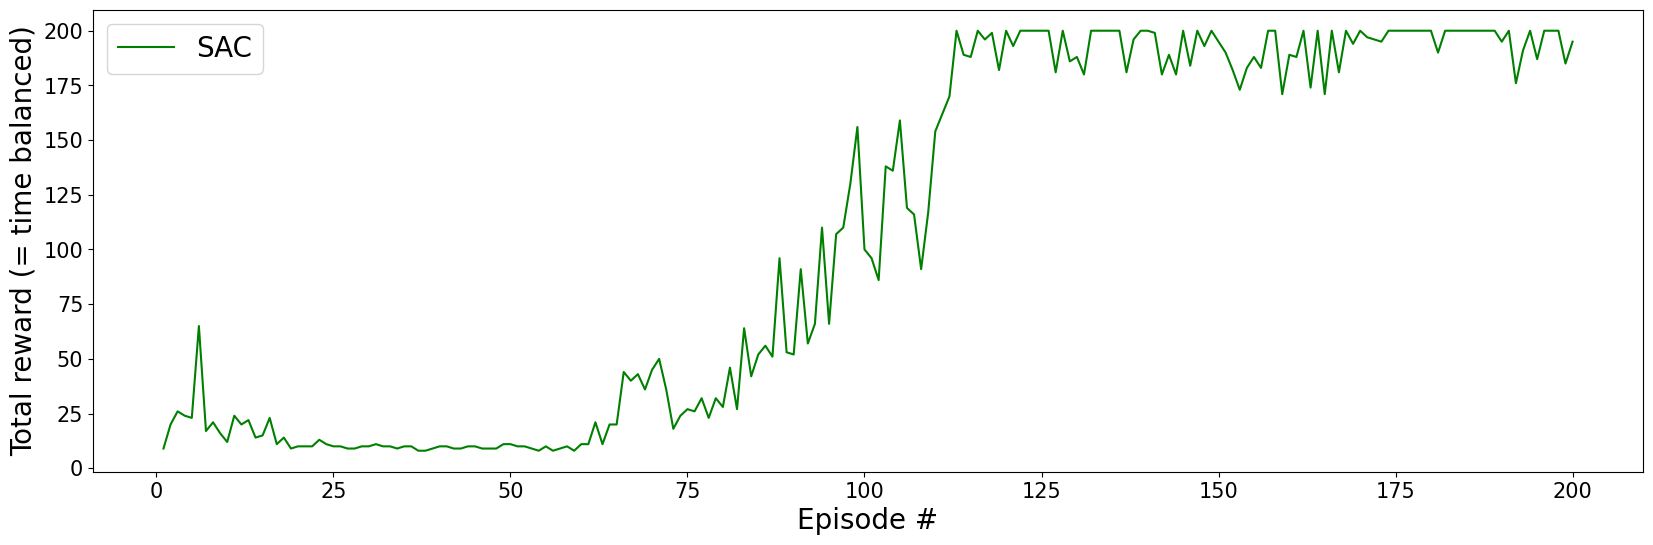

In [21]:
env = gym.make("CartPole-v0")
env.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=1, num_layer_critic=1, lr_act=3e-4, lr_crit=3e-4, alpha=0.2, tau=0.05, batch_size=512, 
            grad_steps=1, device=device)

score_history = train_SAC(agent, env, 200, 200, training_interval=1, update_interval=1, print_num_episodes=5)
plot_scores(score_history)

In [ ]:
# import csv

# # Provided data
# data = """

# """

# # Extract scores from the provided data
# lines = data.strip().split('\n')
# scores = []

# for line in lines:
#     parts = line.split()
#     score_index = parts.index('score') + 1
#     scores.append(parts[score_index])

# # Write scores to a CSV file
# with open('cartpole1_sac_scores.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['score'])
#     for score in scores:
#         writer.writerow([score])

# print("Scores have been written to scores.csv")

## Cartpole-v1

episode 0 score 19.0 avg score 19.0
episode 1 score 17.0 avg score 18.0
episode 2 score 24.0 avg score 20.0
episode 3 score 15.0 avg score 18.8
episode 4 score 16.0 avg score 18.2
episode 5 score 9.0 avg score 16.7
episode 6 score 10.0 avg score 15.7
episode 7 score 10.0 avg score 15.0
episode 8 score 9.0 avg score 14.3
episode 9 score 10.0 avg score 13.9
episode 10 score 10.0 avg score 13.5
episode 11 score 9.0 avg score 13.2
episode 12 score 10.0 avg score 12.9
episode 13 score 8.0 avg score 12.6
episode 14 score 10.0 avg score 12.4
episode 15 score 9.0 avg score 12.2
episode 16 score 9.0 avg score 12.0
episode 17 score 10.0 avg score 11.9
episode 18 score 10.0 avg score 11.8
episode 19 score 8.0 avg score 11.6
episode 20 score 9.0 avg score 11.5
episode 21 score 9.0 avg score 11.4
episode 22 score 10.0 avg score 11.3
episode 23 score 50.0 avg score 12.9
episode 24 score 37.0 avg score 13.9
episode 25 score 41.0 avg score 14.9
episode 26 score 65.0 avg score 16.8
episode 27 score 32.

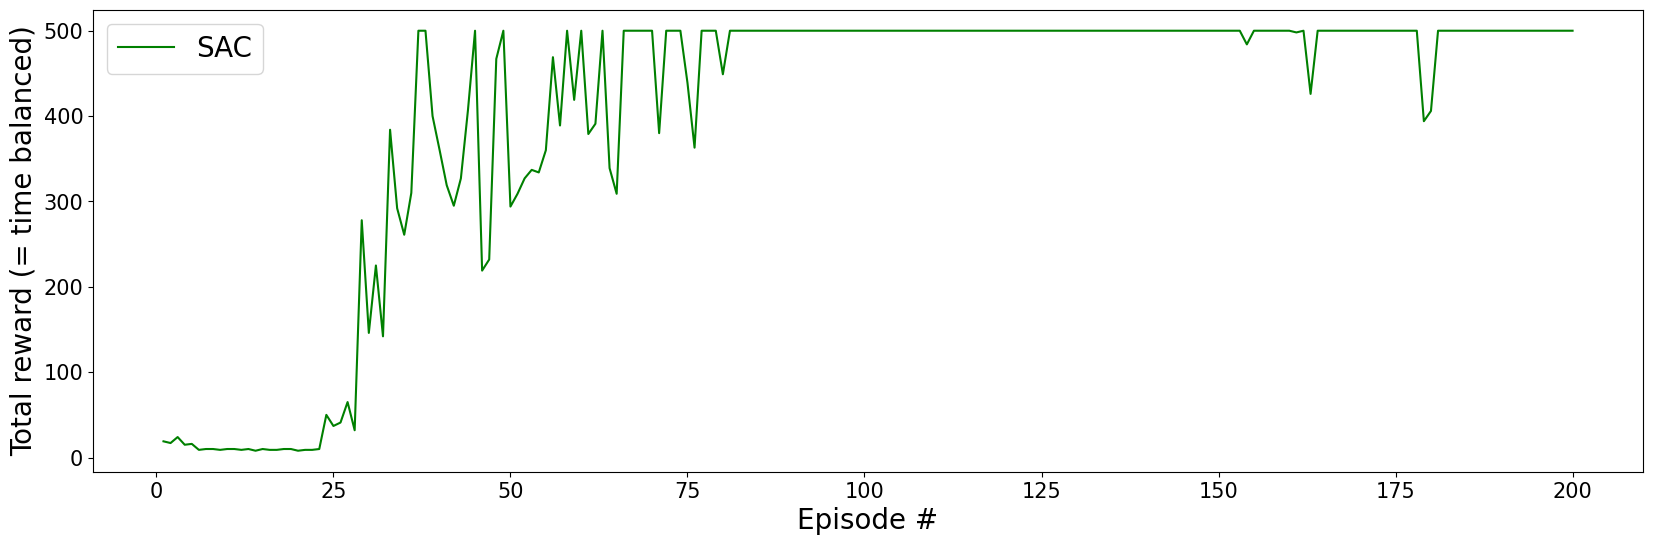

In [40]:
env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, alpha=0.2, tau=0.05, batch_size=64, 
            grad_steps=4, device=device)

score_history = train_SAC(agent, env, 200, 500, training_interval=1, update_interval=1, print_num_episodes=1)
plot_scores(score_history)

## Acrobot

In [46]:
env = gym.make("Acrobot-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, action_dim, buffer_capacity=int(5e5), hidden_dim_actor = 32, hidden_dim_critic=32, 
            num_layer_actor=1, num_layer_critic=1, lr_act=5e-4, lr_crit=5e-4, alpha=0.2, tau=0.05, batch_size=256, 
            grad_steps=1, device=device)

score_history = train_SAC(agent, env, 250, 500, training_interval=1, update_interval=1, print_num_episodes=1)
plot_scores(score_history)

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode 0 score -500.0 avg score -500.0
episode 1 score -500.0 avg score -500.0
episode 2 score -500.0 avg score -500.0
episode 3 score -500.0 avg score -500.0
episode 4 score -500.0 avg score -500.0
episode 5 score -500.0 avg score -500.0
episode 6 score -500.0 avg score -500.0
episode 7 score -500.0 avg score -500.0
episode 8 score -500.0 avg score -500.0
episode 9 score -500.0 avg score -500.0
episode 10 score -500.0 avg score -500.0
episode 11 score -500.0 avg score -500.0
episode 12 score -500.0 avg score -500.0
episode 13 score -500.0 avg score -500.0
episode 14 score -500.0 avg score -500.0
episode 15 score -500.0 avg score -500.0
episode 16 score -500.0 avg score -500.0
episode 17 score -500.0 avg score -500.0


KeyboardInterrupt: 

In [ ]:
import csv

# Provided data
data = """
episode 0 score -500.0 avg score -500.0
episode 1 score -456.0 avg score -478.0
episode 2 score -500.0 avg score -485.3
episode 3 score -500.0 avg score -489.0
episode 4 score -500.0 avg score -491.2
episode 5 score -441.0 avg score -479.4
episode 6 score -500.0 avg score -488.2
episode 7 score -315.0 avg score -451.2
episode 8 score -500.0 avg score -451.2
episode 9 score -422.0 avg score -435.6
episode 10 score -382.0 avg score -423.8
episode 11 score -375.0 avg score -398.8
episode 12 score -288.0 avg score -393.4
episode 13 score -180.0 avg score -329.4
episode 14 score -159.0 avg score -276.8
episode 15 score -412.0 avg score -282.8
episode 16 score -236.0 avg score -255.0
episode 17 score -266.0 avg score -250.6
episode 18 score -251.0 avg score -264.8
episode 19 score -173.0 avg score -267.6
episode 20 score -196.0 avg score -224.4
episode 21 score -403.0 avg score -257.8
episode 22 score -291.0 avg score -262.8
episode 23 score -168.0 avg score -246.2
episode 24 score -157.0 avg score -243.0
episode 25 score -306.0 avg score -265.0
episode 26 score -321.0 avg score -248.6
episode 27 score -222.0 avg score -234.8
episode 28 score -222.0 avg score -245.6
episode 29 score -190.0 avg score -252.2
episode 30 score -190.0 avg score -229.0
episode 31 score -266.0 avg score -218.0
episode 32 score -282.0 avg score -230.0
episode 33 score -289.0 avg score -243.4
episode 34 score -304.0 avg score -266.2
episode 35 score -158.0 avg score -259.8
episode 36 score -148.0 avg score -236.2
episode 37 score -175.0 avg score -214.8
episode 38 score -211.0 avg score -199.2
episode 39 score -196.0 avg score -177.6
episode 40 score -139.0 avg score -173.8
episode 41 score -201.0 avg score -184.4
episode 42 score -163.0 avg score -182.0
episode 43 score -146.0 avg score -169.0
episode 44 score -125.0 avg score -154.8
episode 45 score -119.0 avg score -150.8
episode 46 score -493.0 avg score -209.2
episode 47 score -114.0 avg score -199.4
episode 48 score -101.0 avg score -190.4
episode 49 score -98.0 avg score -185.0
episode 50 score -130.0 avg score -187.2
episode 51 score -108.0 avg score -110.2
episode 52 score -136.0 avg score -114.6
episode 53 score -97.0 avg score -113.8
episode 54 score -126.0 avg score -119.4
episode 55 score -123.0 avg score -118.0
episode 56 score -109.0 avg score -118.2
episode 57 score -116.0 avg score -114.2
episode 58 score -166.0 avg score -128.0
episode 59 score -122.0 avg score -127.2
episode 60 score -115.0 avg score -125.6
episode 61 score -85.0 avg score -120.8
episode 62 score -113.0 avg score -120.2
episode 63 score -94.0 avg score -105.8
episode 64 score -83.0 avg score -98.0
episode 65 score -106.0 avg score -96.2
episode 66 score -107.0 avg score -100.6
episode 67 score -80.0 avg score -94.0
episode 68 score -113.0 avg score -97.8
episode 69 score -110.0 avg score -103.2
episode 70 score -105.0 avg score -103.0
episode 71 score -137.0 avg score -109.0
episode 72 score -110.0 avg score -115.0
episode 73 score -106.0 avg score -113.6
episode 74 score -95.0 avg score -110.6
episode 75 score -103.0 avg score -110.2
episode 76 score -121.0 avg score -107.0
episode 77 score -103.0 avg score -105.6
episode 78 score -86.0 avg score -101.6
episode 79 score -120.0 avg score -106.6
episode 80 score -179.0 avg score -121.8
episode 81 score -93.0 avg score -116.2
episode 82 score -92.0 avg score -114.0
episode 83 score -140.0 avg score -124.8
episode 84 score -134.0 avg score -127.6
episode 85 score -112.0 avg score -114.2
episode 86 score -113.0 avg score -118.2
episode 87 score -83.0 avg score -116.4
episode 88 score -91.0 avg score -106.6
episode 89 score -87.0 avg score -97.2
episode 90 score -132.0 avg score -101.2
episode 91 score -98.0 avg score -98.2
episode 92 score -108.0 avg score -103.2
episode 93 score -115.0 avg score -108.0
episode 94 score -115.0 avg score -113.6
episode 95 score -104.0 avg score -108.0
episode 96 score -86.0 avg score -105.6
episode 97 score -95.0 avg score -103.0
episode 98 score -71.0 avg score -94.2
episode 99 score -91.0 avg score -89.4
episode 100 score -104.0 avg score -89.4
episode 101 score -104.0 avg score -93.0
episode 102 score -84.0 avg score -90.8
episode 103 score -94.0 avg score -95.4
episode 104 score -118.0 avg score -100.8
episode 105 score -113.0 avg score -102.6
episode 106 score -83.0 avg score -98.4
episode 107 score -97.0 avg score -101.0
episode 108 score -123.0 avg score -106.8
episode 109 score -102.0 avg score -103.6
episode 110 score -105.0 avg score -102.0
episode 111 score -111.0 avg score -107.6
episode 112 score -112.0 avg score -110.6
episode 113 score -96.0 avg score -105.2
episode 114 score -224.0 avg score -129.6
episode 115 score -82.0 avg score -125.0
episode 116 score -99.0 avg score -122.6
episode 117 score -86.0 avg score -117.4
episode 118 score -83.0 avg score -114.8
episode 119 score -99.0 avg score -89.8
episode 120 score -131.0 avg score -99.6
episode 121 score -93.0 avg score -98.4
episode 122 score -169.0 avg score -115.0
episode 123 score -84.0 avg score -115.2
episode 124 score -122.0 avg score -119.8
episode 125 score -76.0 avg score -108.8
episode 126 score -84.0 avg score -107.0
episode 127 score -115.0 avg score -96.2
episode 128 score -130.0 avg score -105.4
episode 129 score -104.0 avg score -101.8
episode 130 score -77.0 avg score -102.0
episode 131 score -102.0 avg score -105.6
episode 132 score -116.0 avg score -105.8
episode 133 score -75.0 avg score -94.8
episode 134 score -96.0 avg score -93.2
episode 135 score -118.0 avg score -101.4
episode 136 score -83.0 avg score -97.6
episode 137 score -69.0 avg score -88.2
episode 138 score -100.0 avg score -93.2
episode 139 score -91.0 avg score -92.2
episode 140 score -102.0 avg score -89.0
episode 141 score -92.0 avg score -90.8
episode 142 score -93.0 avg score -95.6
episode 143 score -76.0 avg score -90.8
episode 144 score -95.0 avg score -91.6
episode 145 score -78.0 avg score -86.8
episode 146 score -106.0 avg score -89.6
episode 147 score -92.0 avg score -89.4
episode 148 score -92.0 avg score -92.6
episode 149 score -82.0 avg score -90.0
episode 150 score -77.0 avg score -89.8
episode 151 score -99.0 avg score -88.4
episode 152 score -85.0 avg score -87.0
episode 153 score -121.0 avg score -92.8
episode 154 score -158.0 avg score -108.0
episode 155 score -202.0 avg score -133.0
episode 156 score -104.0 avg score -134.0
episode 157 score -83.0 avg score -133.6
episode 158 score -99.0 avg score -129.2
episode 159 score -84.0 avg score -114.4
episode 160 score -135.0 avg score -101.0
episode 161 score -115.0 avg score -103.2
episode 162 score -113.0 avg score -109.2
episode 163 score -91.0 avg score -107.6
episode 164 score -111.0 avg score -113.0
episode 165 score -76.0 avg score -101.2
episode 166 score -114.0 avg score -101.0
episode 167 score -84.0 avg score -95.2
episode 168 score -78.0 avg score -92.6
episode 169 score -90.0 avg score -88.4
episode 170 score -102.0 avg score -93.6
episode 171 score -85.0 avg score -87.8
episode 172 score -100.0 avg score -91.0
episode 173 score -90.0 avg score -93.4
episode 174 score -95.0 avg score -94.4
episode 175 score -102.0 avg score -94.4
episode 176 score -178.0 avg score -113.0
episode 177 score -89.0 avg score -110.8
episode 178 score -107.0 avg score -114.2
episode 179 score -72.0 avg score -109.6
episode 180 score -70.0 avg score -103.2
episode 181 score -112.0 avg score -90.0
episode 182 score -117.0 avg score -95.6
episode 183 score -107.0 avg score -95.6
episode 184 score -178.0 avg score -116.8
episode 185 score -84.0 avg score -119.6
episode 186 score -100.0 avg score -117.2
episode 187 score -83.0 avg score -110.4
episode 188 score -105.0 avg score -110.0
episode 189 score -84.0 avg score -91.2
episode 190 score -101.0 avg score -94.6
episode 191 score -97.0 avg score -94.0
episode 192 score -107.0 avg score -98.8
episode 193 score -164.0 avg score -110.6
episode 194 score -83.0 avg score -110.4
episode 195 score -99.0 avg score -110.0
episode 196 score -139.0 avg score -118.4
episode 197 score -83.0 avg score -113.6
episode 198 score -103.0 avg score -101.4
episode 199 score -284.0 avg score -141.6
episode 200 score -75.0 avg score -136.8
episode 201 score -90.0 avg score -127.0
episode 202 score -74.0 avg score -125.2
episode 203 score -119.0 avg score -128.4
episode 204 score -103.0 avg score -92.2
episode 205 score -79.0 avg score -93.0
episode 206 score -93.0 avg score -93.6
episode 207 score -75.0 avg score -93.8
episode 208 score -102.0 avg score -90.4
episode 209 score -86.0 avg score -87.0
episode 210 score -84.0 avg score -88.0
episode 211 score -204.0 avg score -110.2
episode 212 score -100.0 avg score -115.2
episode 213 score -90.0 avg score -112.8
episode 214 score -94.0 avg score -114.4
episode 215 score -95.0 avg score -116.6
episode 216 score -69.0 avg score -89.6
episode 217 score -84.0 avg score -86.4
episode 218 score -100.0 avg score -88.4
episode 219 score -79.0 avg score -85.4
episode 220 score -93.0 avg score -85.0
episode 221 score -84.0 avg score -88.0
episode 222 score -104.0 avg score -92.0
episode 223 score -69.0 avg score -85.8
episode 224 score -82.0 avg score -86.4
episode 225 score -97.0 avg score -87.2
episode 226 score -108.0 avg score -92.0
episode 227 score -84.0 avg score -88.0
episode 228 score -78.0 avg score -89.8
episode 229 score -109.0 avg score -95.2
episode 230 score -90.0 avg score -93.8
episode 231 score -102.0 avg score -92.6
episode 232 score -85.0 avg score -92.8
episode 233 score -84.0 avg score -94.0
episode 234 score -87.0 avg score -89.6
episode 235 score -88.0 avg score -89.2
episode 236 score -76.0 avg score -84.0
episode 237 score -100.0 avg score -87.0
episode 238 score -119.0 avg score -94.0
episode 239 score -80.0 avg score -92.6
episode 240 score -71.0 avg score -89.2
episode 241 score -106.0 avg score -95.2
episode 242 score -122.0 avg score -99.6
episode 243 score -85.0 avg score -92.8
episode 244 score -85.0 avg score -93.8
episode 245 score -109.0 avg score -101.4
episode 246 score -109.0 avg score -102.0
episode 247 score -83.0 avg score -94.2
episode 248 score -137.0 avg score -104.6
episode 249 score -133.0 avg score -114.2
"""

# Extract scores from the provided data
lines = data.strip().split('\n')
scores = []

for line in lines:
    parts = line.split()
    score_index = parts.index('score') + 1
    scores.append(parts[score_index])

# Write scores to a CSV file
with open('acrobotv1_sac_256_1_3e-4_025_2_32_2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['score'])
    for score in scores:
        writer.writerow([score])

print("Scores have been written to scores.csv")